## Dwarf galaxy discovery metric ##

(contributed by Jeff Carlin)

In [1]:
import os
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import MAF
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

### Methodology for Local Volume galaxies' dwarf satellites:
We use the latest tables from the [Local Volume Galaxies Database](http://www.sao.ru/lv/lvgdb/]) (based on Karachentsev et al. 2013), limiting our selection to Dec < 35 deg. We calculate the stellar mass of all galaxies using their total K−band luminosities, assuming mass-to-light of 1.0 in K. We then limit the sample to galaxies with $M_{star} > 10^7 M_{Sun}$ (removing the faintest systems, which will not be expected to have significant dwarf satellite populations; e.g., Dooley et al. 2017b,a); this leaves a total of 302 galaxies between 1.3 < D < 9 Mpc (of which 139 are within 6 Mpc).

The metric is evaluated at the positions of known galaxies by defining a custom `UserPointSlicer` object with the positions and distances to galaxies from the catalog described above. The function that creates this slicer is called `generateKnownLVDwarfSlicer`. (Note, however, that the metric can be calculated with a healpix map and a fixed distance limit; see below for more on this method.)

To estimate the detectability of dwarf satellites, we begin by considering the unresolved background galaxies and foreground Milky Way stars that contaminate a CMD selection of candidate RGB stars. For each of the galaxies in our sample, we extract the expected number of galaxies per square arcmin using the **GalaxyCountsMetric**, and the expected stellar density from the **StarDensityMetric**. We apply a scaling factor (`cmd_frac`=0.1 by default) to account for the sub-region of the CMD inhabited by our tracers (RGB stars) relative to the full-CMD area spanned by the simulations, and an additional scaling factor to account for unresolved galaxy contamination (`stargal_contamination`=0.4 by default) in a stellar sample selection at the faint end. Then, with an estimated number of contaminants, we calculate the number of stars required to be detected to reach a given Poisson-limited signal-to-noise (S/N > 10 by default). For the region around each Local Volume galaxy, we use a function called `makeFakeLF` which reads in a [PARSEC](http://stev.oapd.inaf.it/cgi-bin/cmd) luminosity function for an old (10 Gyr), metal-poor (\[M/H\] = −1.5) population and generates fake dwarf galaxies using a simulated luminosity function (in g and i bands). We generate dwarfs with known luminosities, continuing to fainter luminosities until we reach the S/N threshold. Our final figure of merit (FoM) is the number of Local Volume galaxies for which the faintest detectable dwarf satellite galaxy is fainter than our chosen dwarf luminosity threshold ($M_V = −7$).

In [3]:
opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/Users/yoachim/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db
baseline_v2.1_10yrs


## Set up and run metric 1: number of host galaxies meeting required depth

In [5]:
# Create a slicer based on known galaxies within 9 Mpc, with stellar mass > 10^7 M_Sun:

lv_slicer = maf.generate_known_lv_dwarf_slicer()

In [6]:
# Set up the metric

mymetric = maf.LVDwarfsMetric() # for the discrete LV galaxies

In [7]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits

sqlconstraint = '(filter = "g" OR filter = "i")'
# sqlconstraint = None   # no constraint, make all visits available

In [8]:
# Define the maps needed -- the stellar density in i band is required, dust map is not (default will be fine)
starmap = maf.StellarDensityMap(filtername='i')

In [9]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(mymetric, lv_slicer, sqlconstraint, maps_list=[starmap], run_name=runName,
                         plot_dict={'nTicks': 7})

In [10]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'LVDwarfs_metric': bundle}, opsim_fname, out_dir='test', results_db=None)
# And calculate the metric
g.run_all()

{'SkyMap': 1, 'Histogram': 2}

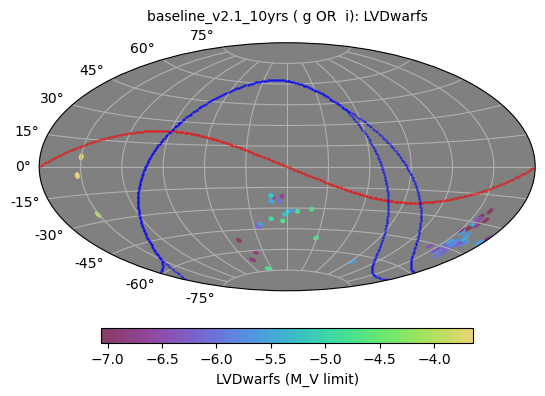

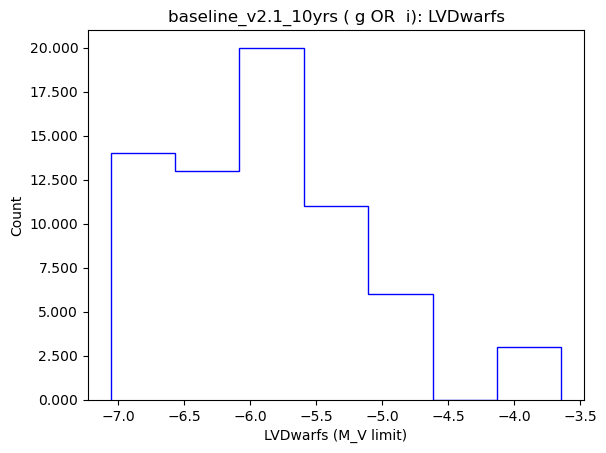

In [11]:
bundle.set_plot_dict({'nTicks': 7})
bundle.plot()

### Calculate the metric

The Local Volume dwarf satellites metric is simply the number of hosts to which we meet a given dwarf detection threshold. We choose a threshold of $M_V < -6.4$ (which corresponds to stellar mass of about $5\times10^4 M_{\rm Sun}$), and report the total number (out of 302 input galaxies) that reach this threshold.

We also look at the number of hosts which reach -7.0 ($M_V < -7.0$ is about $10^4 M_{\rm Sun}$), but this falls close to the edge of the distribution.

In [12]:
cutoff = -6.4
summary_metric = maf.CountBeyondThreshold(lower_threshold=cutoff, metric_name='Total detected')
bundle.set_summary_metrics([summary_metric])
bundle.compute_summary_stats()
print(f"Number (out of {len(lv_slicer)}) of galaxies surveyed to the requested depth {cutoff}: "\
      f"{bundle.summary_values['Total detected']}")

cutoff = -7.0
summary_metric = maf.CountBeyondThreshold(lower_threshold=cutoff, metric_name='Total detected')
bundle.set_summary_metrics([summary_metric])
bundle.compute_summary_stats()
print(f"Number (out of {len(lv_slicer)}) of galaxies surveyed to the requested depth {cutoff}: "\
      f"{bundle.summary_values['Total detected']}")

Number (out of 302) of galaxies surveyed to the requested depth -6.4: 48
Number (out of 302) of galaxies surveyed to the requested depth -7.0: 63


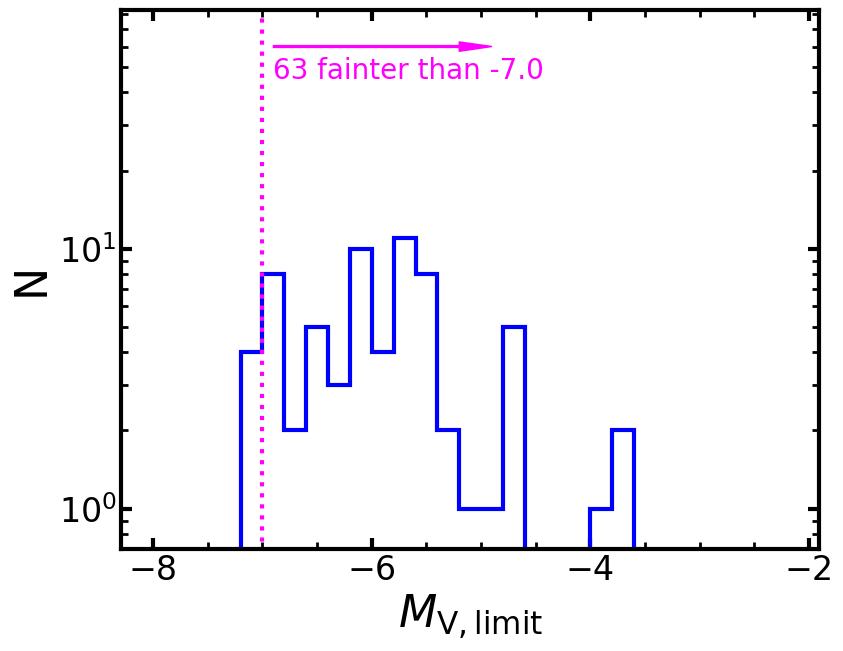

In [13]:
params = {
   'axes.labelsize': 32,
   'font.size': 24,
   'legend.fontsize': 20,
#   'xtick.labelsize': 16,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 8,
   'xtick.minor.size': 5,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 8,
   'ytick.minor.size': 5,
   'ytick.direction': 'in',
   'ytick.right': True,
#   'ytick.labelsize': 20,
#   'text.usetex': True,
#   'text.latex.preamble': r'\boldmath',
   'figure.figsize': [9, 7],
   'figure.facecolor': 'White'
    }

plt.rcParams.update(params)

plt.hist(bundle.metric_values.compressed(), bins=np.arange(-8, -2, 0.2), log=True, histtype='step',
         color='Blue', label='All', linewidth=3)
plt.vlines(cutoff, 0, 200, color='magenta', linestyle=':', linewidth=3)
plt.arrow(cutoff+0.1, 60.0, 2, 0, color='magenta', width=1, length_includes_head=True, head_width=5, head_length=0.3)
plt.text(cutoff+0.1, 45, str(bundle.summary_values['Total detected']) +' fainter than ' + str(cutoff), 
         color='magenta', fontsize='small')
plt.ylim(0.7, 83)

plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

### Metric 2: total sky area within 4 Mpc that meets the required depth

The second Local Volume dwarf satellites metric is total sky area at which the survey meets a given dwarf detection threshold at some distance. We choose a threshold of $M_V < -5.5$ (which corresponds to stellar mass of about $2\times10^4 M_{\rm Sun}$), and report the total sky area to which we reach this threshold.

In [15]:
nside = 32

mymetric2 = maf.LVDwarfsMetric(distlim=4.0*u.Mpc) # for a distance limit, healpix map
dustmap = maf.DustMap(nside=nside) # Not necessary, but removes warning message
healpix_slicer = maf.HealpixSlicer(nside=nside, use_cache=False)
bundle2 = maf.MetricBundle(mymetric2, healpix_slicer, sqlconstraint,
                           maps_list=[starmap, dustmap], run_name=runName)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [16]:
g2 = maf.MetricBundleGroup({'LVDwarfs_area_metric': bundle2}, opsim_fname, out_dir='test', results_db=None)
g2.run_all()

{'SkyMap': 1, 'Histogram': 2}

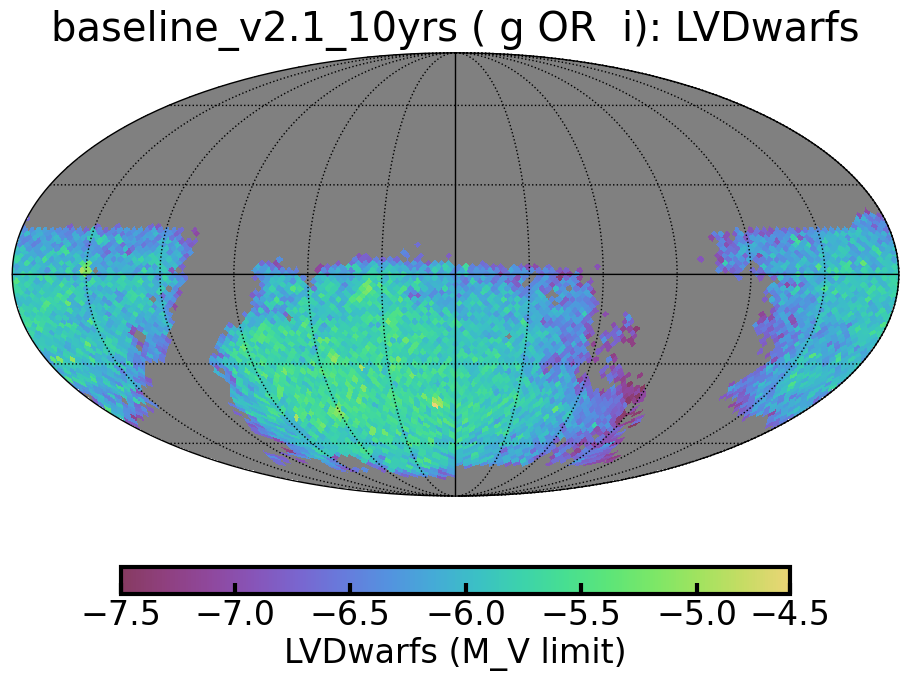

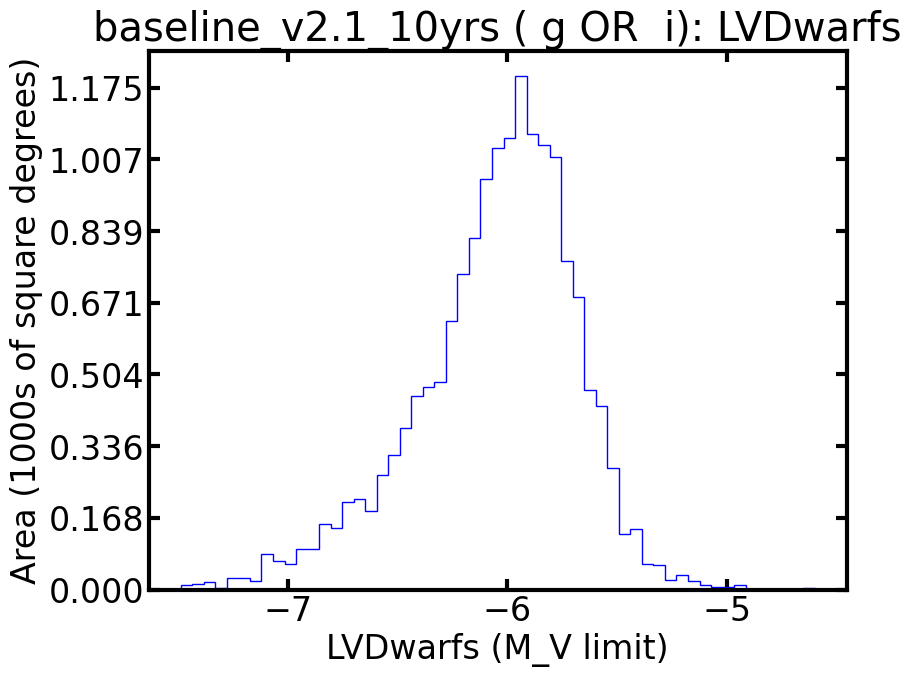

In [17]:
bundle2.set_plot_dict({'nTicks': 7})
bundle2.plot()

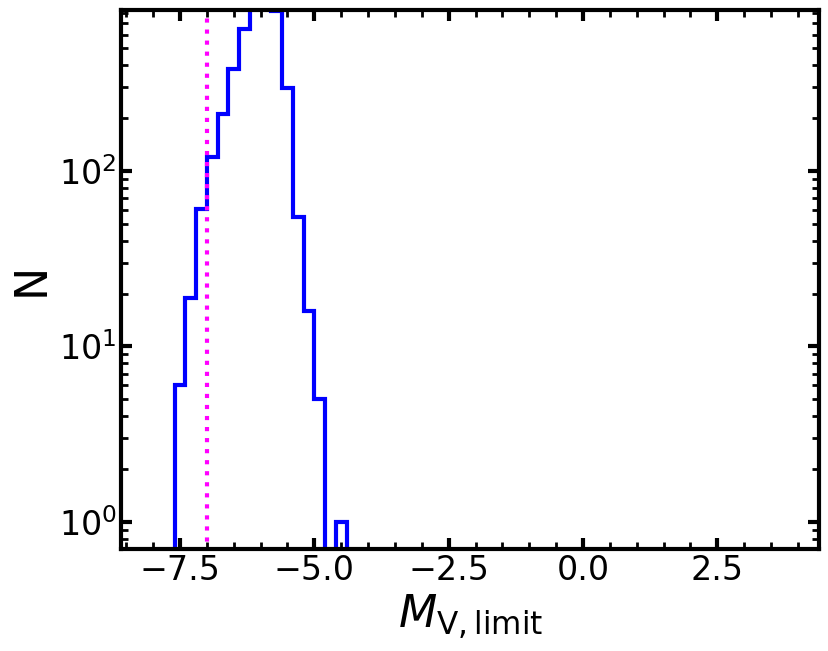

In [18]:
plt.hist(bundle2.metric_values.compressed(), bins=np.arange(-8, 4, 0.2), log=True, histtype='step',
         color='Blue', linewidth=3)
plt.vlines(cutoff, 0, 1000, color='magenta', linestyle=':', linewidth=3)
plt.ylim(0.7, 830)
#plt.xlim(-9.3, 1.8)
plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

In [19]:
summary_area = maf.AreaThresholdMetric(lower_threshold=cutoff)
bundle2.set_summary_metrics([summary_area])
bundle2.compute_summary_stats()
bundle2.summary_values

{'AreaThreshold': 16208.438876318052}

### Metric 3: detection limits for Milky Way dwarfs in the south Galactic cap

In [20]:
sql_scp = '(filter = "i" OR filter = "g") and fieldDec < -60'

In [21]:
mymetric3 = maf.LVDwarfsMetric(distlim=0.1*u.Mpc) # for a distance limit, healpix map
healpix_slicer3 = maf.HealpixSlicer(nside=32, use_cache=False)
bundle3 = maf.MetricBundle(mymetric3, healpix_slicer3, sql_scp, maps_list=[starmap, dustmap], run_name=runName)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [23]:
g3 = maf.MetricBundleGroup({'LVDwarfs_SCP_metric': bundle3}, opsim_fname, out_dir='test', results_db=None)
g3.run_all()

{'SkyMap': 1, 'Histogram': 2}

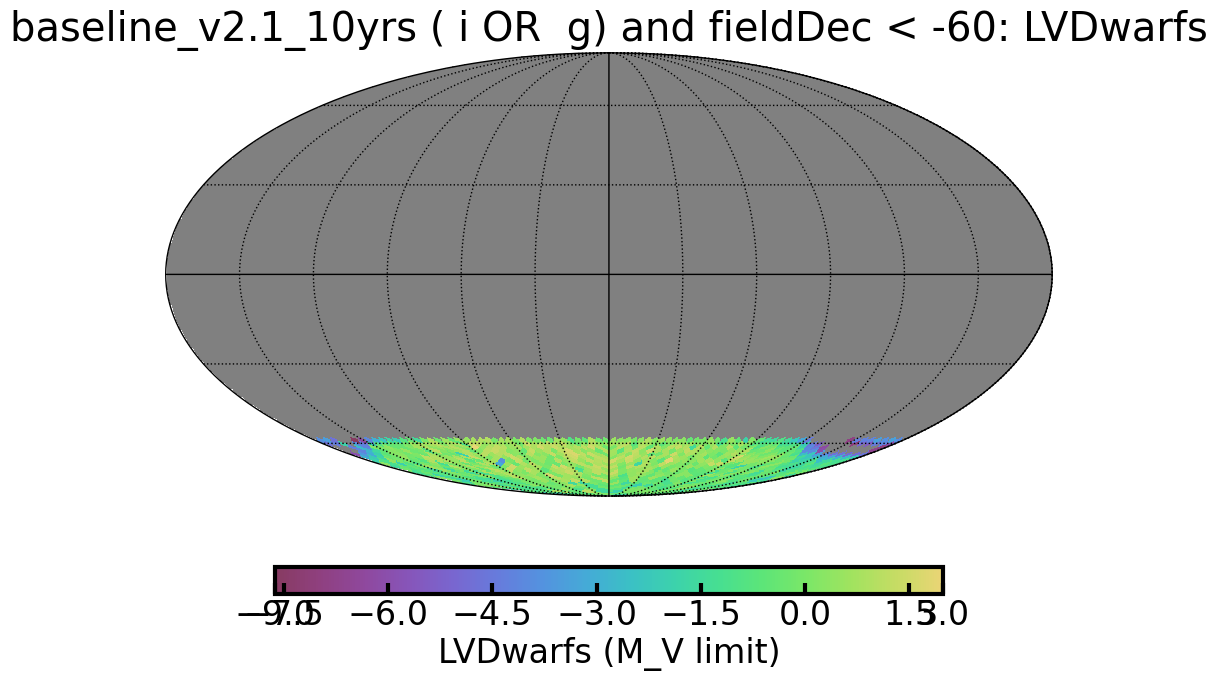

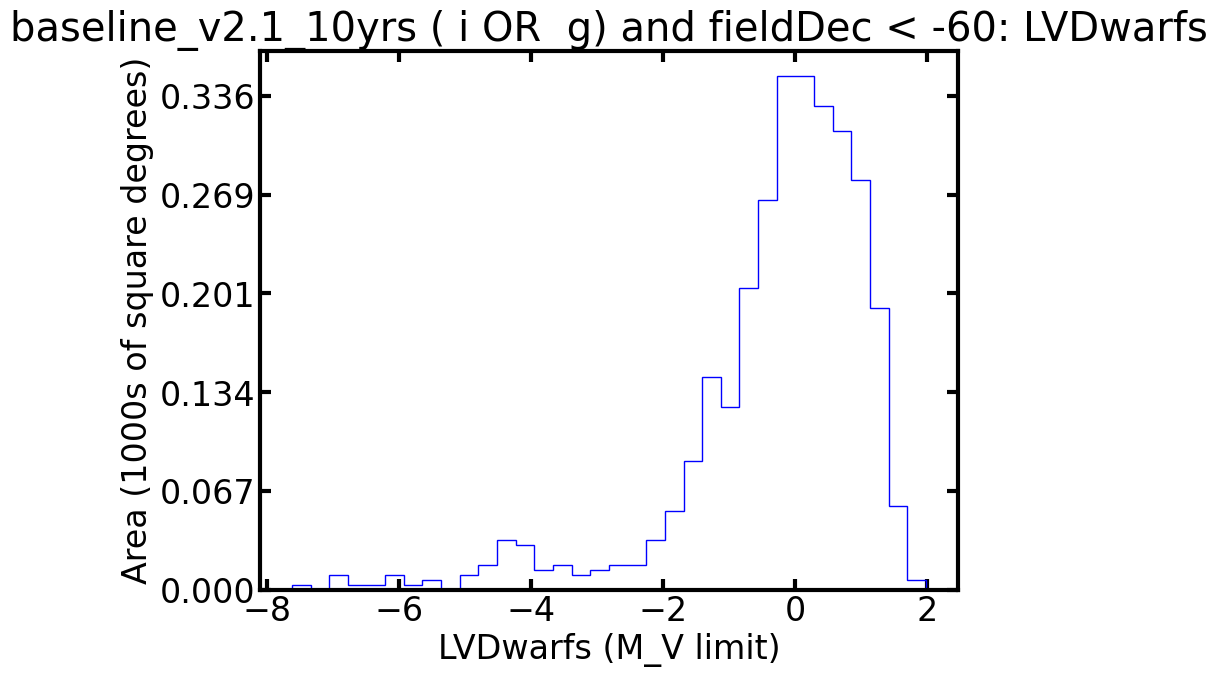

In [24]:
bundle3.set_plot_dict({'nTicks': 7})
bundle3.plot()

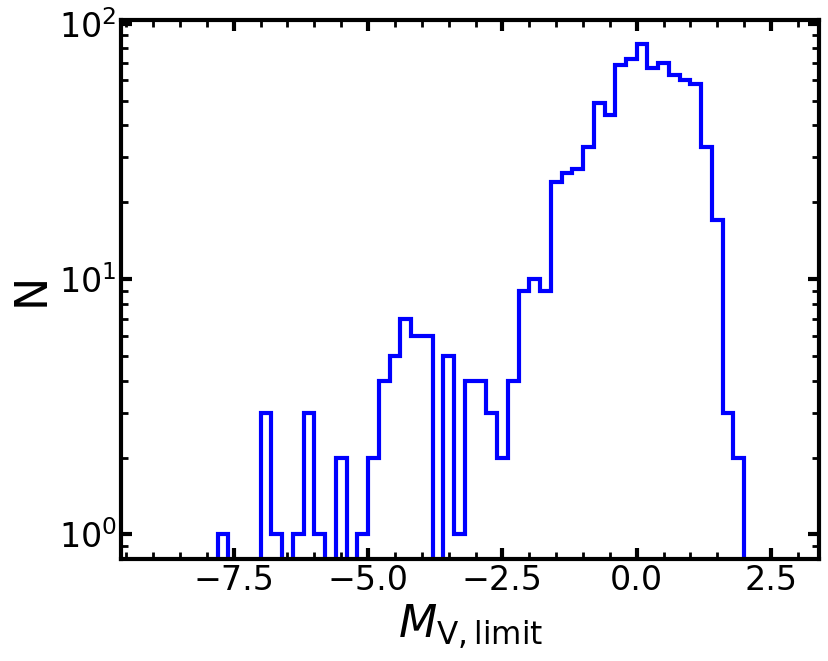

In [25]:
plt.hist(bundle3.metric_values.compressed(), bins=np.arange(-9, 3, 0.2), log=True, histtype='step',
         color='Blue', linewidth=3)
# plt.ylim(0.7, 830)
#plt.xlim(-5.3, 5.3)
plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

In [ ]:
### Do we want to maximize the area below some limiting M_V, or maximize the median, limiting M_V, etc?

In [26]:
summary_area = maf.AreaThresholdMetric(lower_threshold=0.0)
summary_median = maf.MedianMetric()
bundle3.set_summary_metrics([summary_area, summary_median])
bundle3.compute_summary_stats()
bundle3.summary_values

{'AreaThreshold': 1530.8716088651681, 'Median': 0.027294532735705396}